# Predicting regional COVID-19 hospital admissions in Sweden using mobility data
This notebook accompanies the manuscript "Predicting regional COVID-19 hospital admissions in Sweden using mobility data" and contains code for generating figure 1. To run it requires the following files: "statistik-covid19-inskrivna.xlsx", "VT.xlsx","ST.xlsx" and "param_IC.pkl".

Questions and comments: gerlee@chalmers.se

In [49]:
#import modules
from math import *
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 21})
import scipy.stats as stats
from scipy.optimize import curve_fit,leastsq
from scipy.integrate import odeint, ode
from scipy.interpolate import interp1d
import numpy as np
import pandas
from scipy.interpolate import interp1d

In [50]:
file = pandas.read_excel('statistik-covid19-inskrivna_v2.xlsx',sheet_name="Inskrivna i slutenvård")
data = [['Sthlm', 8], ['VGR', 9], ['Skåne', 10],['Östergötland',11],['Jönköping',12],['Södermanland',13],['Uppsala',14],['Gävelborg',15],['Västmanland',16],['Örebro',17],['Norrbotten',18],['Dalarna',19],['Västernorrland',20],['Värmland',21],['Halland',22],['Kalmar',23],['Kronoberg',24],['Västerbotten',25],['Jämtland',26],['Blekinge',27],['Gotland',28]] 
regioner = pandas.DataFrame(data, columns = ['region', 'index']) 
vald_region='VGR'
temp=regioner.loc[regioner['region']==vald_region] #find the VGR-data
index=temp['index'].values 
R = file.iloc[index[0]]
R=R.replace(' ','X') #replace missing data with 0
R=R.replace('X',0)
ind = np.arange(3,len(R),2) #find admissions
I = R.iloc[ind].values 
I=np.insert(I,0,[0,0,0,0]) #add four weeks with no cases
I=I[:-2] #remove last data point
veckor = np.arange(0,len(I),1) #define week numbers

In [51]:
#Parameters
startvecka=10-4 #first week with case data minus the padding
Tmax=53 #length of prediction
N=1725881 #population of VGR
pv=0.023 #fraction of cases that are admitted

rho=7*1/5.1 #incubation rate
gamma=7*1/5 #recovery rate

delay=3 #time from infection to admission

In [52]:
#Load data from Västtrafik
df = pandas.read_excel('VT.xlsx') 
values = df['Unnamed: 4'].values
diff = np.array(values[4:])
diff=np.insert(diff,0,[0.2,0.2])#baseline travel
T=np.arange(7,7+len(diff),1) 

In [53]:
resfkn = interp1d(T-startvecka,diff,kind="linear",fill_value="extrapolate") #create function

In [54]:
#time-dependent infectivity
def beta(t,a,b):
    return a+b*resfkn(t)

In [55]:
#the RHS of the SEIR-model
#S=x1
#E=x2
#I=x3
#R=x4
def dx(x,t,a,b,lag):
    x1, x2, x3, x4= x[0], x[1], x[2], x[3]
    
    dx1 =  -x1*beta(t-lag,a,b)*x3/N
    dx2 = x1*beta(t-lag,a,b)*x3/N - rho*x2
    dx3 = rho*x2 - gamma*x3
    dx4 = gamma*x3
    
    return [dx1, dx2, dx3, dx4]

In [56]:
#define the model output
def pred_inlagda(t,a,b,lag):
    #intialvillkor
    x0 = [N-1,0,1,0] #initial conditions
    x = odeint(dx, x0, t,args=(a,b,lag))
    return pv*x[:,2]

In [58]:
#performing global grid search
#For better parameter estimates this can be rerun with higher value of n around the expected optimum
I_train=I
veckor_train=veckor
n=10
ah=np.linspace(3,5,n)
bh=np.linspace(4,6,n)

E=np.zeros((len(ah),len(bh)))
for i in range(n):
    print(i)
    for j in range(n):
        P=pred_inlagda(veckor_train,ah[i],bh[j],delay)
        E[i,j]=np.sqrt(np.sum((P-I_train)**2)/len(veckor_train))

0
1
2
3
4
5
6
7
8
9


In [60]:
#Extract parameters with smallest error
optind = np.where(E == np.amin(E))
afit = ah[optind[0]]
bfit = bh[optind[1]]

print("Minimum RMSE: ",E[optind])
print("a=",afit,"b=",bfit)

Minimum RMSE:  [52.76745559]
a= [4.11111111] b= [5.77777778]


In [61]:
#performing local search
I_train=I
veckor_train=veckor
fit, cov = curve_fit(pred_inlagda,veckor_train,I_train,bounds=([2,2,3-0.001],[7,7,3+0.001]),p0=(afit,bfit,3))

In [63]:
P=pred_inlagda(veckor_train,fit[0],fit[1],delay)
E=np.sqrt(np.sum((P-I_train)**2)/len(veckor_train))
print("Model error (RMSE)=",E,"admissions/week")

Model error (RMSE)= 40.68934876437218 admissions/week


In [64]:
#Genererate confidence intervals
M=100
t=np.linspace(0,Tmax-startvecka,200)
P=np.zeros((M,int(len(t))))
perr = np.sqrt(np.diag(cov))
for i in range(M):
    a_r = np.random.normal(fit[0],perr[0],1)
    b_r = np.random.normal(fit[1],perr[1],1)
    P[i,:]=pred_inlagda(t,a_r,b_r,delay)
Pu=np.percentile(P,97.5,axis=0)
Pl=np.percentile(P,2.5,axis=0)

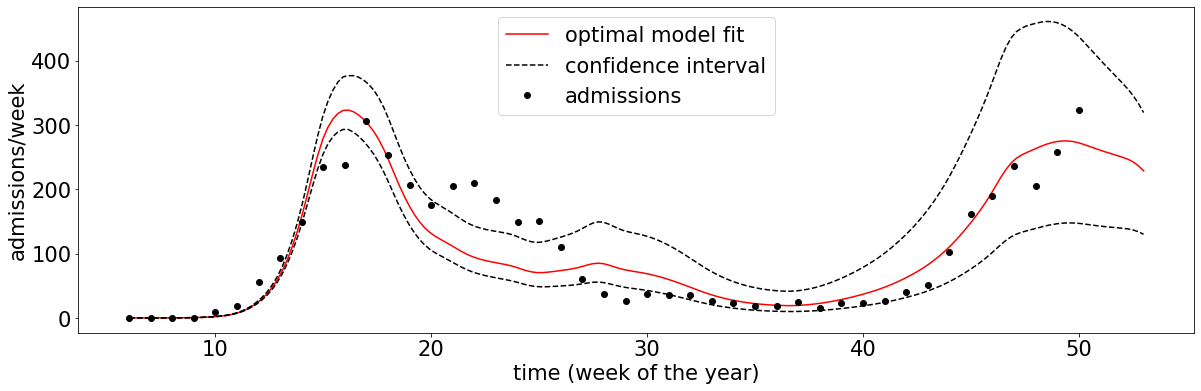

In [65]:
#plot the results
t=np.linspace(0,Tmax-startvecka,200)
fig, axes = plt.subplots(1,1,figsize=(20,6))
pred = pred_inlagda(t,fit[0],fit[1],delay)

axes.plot(t+startvecka,pred,'r',label="optimal model fit")
axes.plot(t+startvecka,Pu,'k--',label="confidence interval")
axes.plot(t+startvecka,Pl,'k--')

axes.plot(veckor+startvecka,I,'ko',label="admissions")

axes.set_xlabel('time (week of the year)')
axes.set_ylabel('admissions/week')
axes.legend()

In [66]:
#save output
tp=np.arange(0,Tmax-startvecka,1)
pred = pred_inlagda(tp,fit[0],fit[1],delay)

np.savetxt('tid.csv',tp+startvecka, delimiter=',')
np.savetxt('inlagda.csv',np.round(pred), delimiter=',')

In [40]:
#calculate model fit when amount of training data is varied
A=np.array([])
B=np.array([])
RMSE=np.array([])
MAPE=np.array([])

hor=3
tt=np.arange(20-startvecka,len(I)-hor,1)
for k in tt:
    I_train=I[0:k]
    veckor_train=veckor[0:k]
    I_test=I[0:k+hor]
    veckor_test=veckor[0:k+hor]
    
    fit, cov = curve_fit(pred_inlagda,veckor_train,I_train,bounds=([2,2,3-0.001],[7,7,3+0.001]),p0=(afit,bfit,3))
    
    A=np.append(A,fit[0])
    B=np.append(B,fit[1])
    Pp=pred_inlagda(veckor,fit[0],fit[1],delay)
    ep=np.sqrt(np.sum((Pp[k:k+hor]-I[k:k+hor])**2)/hor)
    mp=np.sum(np.abs(Pp[k:k+hor]-I[k:k+hor])/I[k:k+hor])/hor
        
    RMSE=np.append(RMSE,ep)
    MAPE=np.append(MAPE,mp)
    
    print("k=",k,"a=",A[-1],"b=",B[-1])
    


k= 14 a= 4.111111132408931 b= 5.777777788819289
k= 15 a= 4.072650012371688 b= 5.26659203322404
k= 16 a= 4.067545848405311 b= 5.166473525135157
k= 17 a= 4.081958011976204 b= 5.209632561782064
k= 18 a= 4.0687543180103845 b= 5.128059091876735
k= 19 a= 4.071659028233847 b= 5.161987070595979
k= 20 a= 4.071569109896945 b= 5.175751685269154
k= 21 a= 4.085837713810124 b= 5.277330830867459
k= 22 a= 4.096594329854757 b= 5.384246646699228
k= 23 a= 4.089415003673593 b= 5.424902167140414
k= 24 a= 4.10002486641403 b= 5.504148635106063
k= 25 a= 4.103492955206271 b= 5.5497338285663655
k= 26 a= 4.111065854822719 b= 5.583162528875862
k= 27 a= 4.117584830108623 b= 5.616002216854787
k= 28 a= 4.107456925169225 b= 5.580925461528913
k= 29 a= 4.111058562957287 b= 5.586023257422947
k= 30 a= 4.105431434407158 b= 5.577849239877939
k= 31 a= 4.1105290904192495 b= 5.595664507676198
k= 32 a= 4.09801517908938 b= 5.557421718711891
k= 33 a= 4.096657551096015 b= 5.57298097948046
k= 34 a= 4.102462109989957 b= 5.577519506

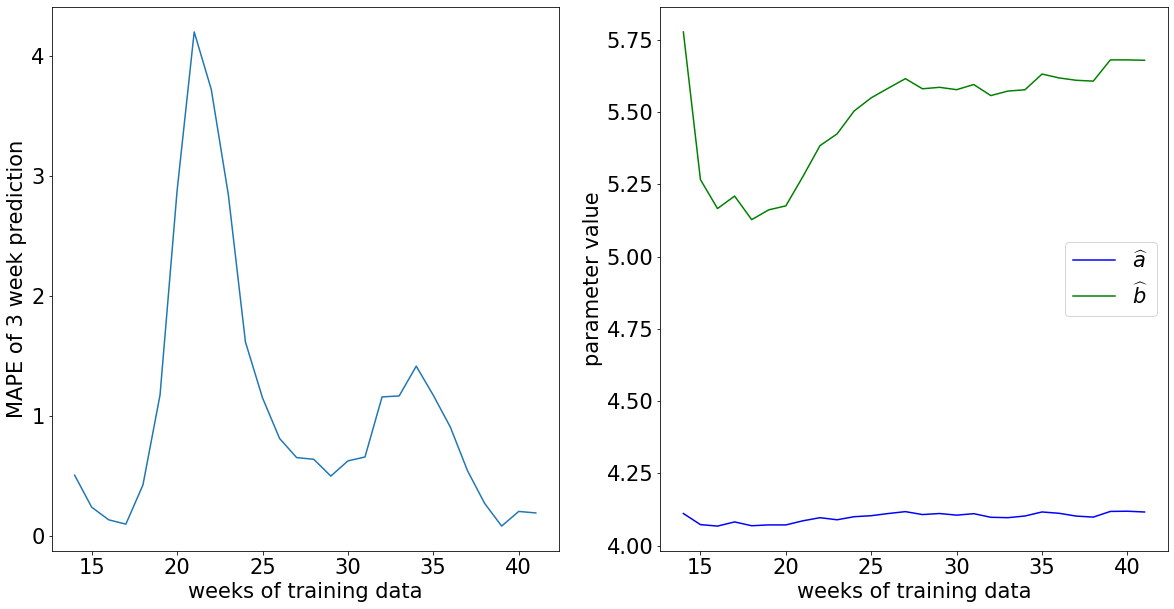

In [69]:
#plot how MAPE and parameter estimates change
t=np.linspace(0,41,100)
trans=np.linspace(0,1,len(A))
P=pred_inlagda(t,A[-1],B[-1],delay)
Pt=pred_inlagda(veckor,A[-1],B[-1],delay)


fig, axes = plt.subplots(1,2,figsize=(20,10))

axes[0].plot(tt+0*startvecka,MAPE)
axes[0].set_xlabel('weeks of training data')
axes[0].set_ylabel('MAPE of 3 week prediction')


axes[1].plot(tt+0*startvecka,A,'b',label="$\widehat{a}$")
axes[1].plot(tt+0*startvecka,B,'g',label="$\widehat{b}$")
axes[1].set_xlabel('weeks of training data')
axes[1].set_ylabel('parameter value')
axes[1].legend()